## Часть 3 Обучение Нейросети на батчах

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Библиотеки для части 3

In [ ]:
# Библиотеки для НС
import keras
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend

# Прочие библиотеки
import os 
import math
import numpy as np

import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков

# Для загрузки изображений в xTest
from PIL import Image # импортируем модель Image для работы с изображениями
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями

In [ ]:
# Загрузка подготовленных NumPy батчей 
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/cars-carvana-batches_size_8_640w_480h.zip -d /content/

Выполню проверку размерностей моих батчей

In [ ]:
x_path = f'/content/cars-carvana-batches_size_8_640w_480h/train/batch_0.npy'
y_path = f'/content/cars-carvana-batches_size_8_640w_480h/train_masks/batch_0.npy'

x = np.load(x_path)
y = np.load(y_path)

In [ ]:
print("x.shape", x.shape)
print("y.shape", y.shape)

x.shape (8, 480, 640, 3)
y.shape (8, 480, 640, 2)


Размерности батчей верны!

### DataLoader моих батчей в НС

In [ ]:
# Свой DataGenerator
class DataLoader(utils.Sequence):
    def __init__(self, path_to_x_batches, path_to_y_batches):
        self.path_to_x_batches = path_to_x_batches
        self.path_to_y_batches = path_to_y_batches

    # Генерируем конкретный батч
    def __getitem__(self, index): # index - приходит от фунции тренировки НС
        x_batch = np.load(f"{self.path_to_x_batches}/batch_{index}.npy")
        y_batch = np.load(f"{self.path_to_y_batches}/batch_{index}.npy")

        return x_batch, y_batch

    # Этот метод должен возращать число батчей. Неявно будет вызываться НС при обучении
    def __len__(self):
        return len(os.listdir(self.path_to_x_batches))

In [ ]:
path_to_x_train_batches = "cars-carvana-batches_size_8_640w_480h/train"
path_to_y_train_batches = "cars-carvana-batches_size_8_640w_480h/train_masks"

path_to_x_val_batches = "cars-carvana-batches_size_8_640w_480h/val"
path_to_y_val_batches = "cars-carvana-batches_size_8_640w_480h/val_masks"

In [ ]:
train_batches_count = len(os.listdir(path_to_x_train_batches))
val_batches_count   = len(os.listdir(path_to_x_val_batches))

print("Число батчей в train")
print(train_batches_count)
print("Число батчей в val")
print(val_batches_count)

Число батчей в train
128
Число батчей в val
32


In [ ]:
# Объекты-загрузчики батчей 
train_loader = DataLoader(path_to_x_train_batches, path_to_y_train_batches) 
val_loader   = DataLoader(path_to_x_val_batches, path_to_y_val_batches) 

In [ ]:
print("train_loader[0]")
print(train_loader[0][0].shape)
print("train_loader[0]")
print(train_loader[0][1].shape)

train_loader[0]
(8, 480, 640, 3)
train_loader[0]
(8, 480, 640, 2)


### Модель нейронной сети

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * backend.sum(y_true * y_pred) + 1.) / (backend.sum(y_true) + backend.sum(y_pred) + 1.)

In [ ]:
def custom_unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1 DOWN
    x = layers.Conv2D(64, (3, 3), padding='same', activation = "relu")(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation = "relu")(x)

    pooled = layers.MaxPool2D(2)(x)
    pooled = layers.Dropout(0.3)(pooled)
    block_out_1 = x
    pooled_1 = pooled


    # Block 2 DOWN

    x = layers.Conv2D(128, (3, 3), padding='same', activation = "relu")(pooled_1)
    x = layers.Conv2D(128, (3, 3), padding='same', activation = "relu")(x)

    pooled = layers.MaxPool2D(2)(x)
    pooled = layers.Dropout(0.3)(pooled)
    block_out_2 = x
    pooled_2 = pooled


    # Block 3 DOWN

    x = layers.Conv2D(256, (3, 3), padding='same', activation = "relu")(pooled_2)
    x = layers.Conv2D(256, (3, 3), padding='same', activation = "relu")(x)

    pooled = layers.MaxPool2D(2)(x)
    pooled = layers.Dropout(0.3)(pooled)
    block_out_3 = x
    pooled_3 = pooled

    # Block 4 DOWN

    x = layers.Conv2D(512, (3, 3), padding='same', activation = "relu")(pooled_3)
    x = layers.Conv2D(512, (3, 3), padding='same', activation = "relu")(x)

    pooled = layers.MaxPool2D(2)(x)
    pooled = layers.Dropout(0.3)(pooled)
    block_out_4 = x
    pooled_4 = pooled

    # Middle Block

    x = layers.Conv2D(1024, (3, 3), padding='same', activation = "relu")(pooled_4)
    x = layers.Conv2D(1024, (3, 3), padding='same', activation = "relu")(x)
    middle_block_out = x

    # Block 4 UP

    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(middle_block_out)
    x = layers.concatenate([x, block_out_4])
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(512, (3, 3), padding='same', activation = "relu")(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation = "relu")(x)
    block_up_out_4 = x

    # Block 3 UP

    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(block_up_out_4)
    x = layers.concatenate([x, block_out_3])
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation = "relu")(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation = "relu")(x)
    block_up_out_3 = x

    # Block 2 UP

    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(block_up_out_3)
    x = layers.concatenate([x, block_out_2])
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation = "relu")(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation = "relu")(x)
    block_up_out_2 = x

    # Block 1 UP

    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(block_up_out_2)
    x = layers.concatenate([x, block_out_1])
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation = "relu")(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation = "relu")(x)
    block_up_out_1 = x

    outputs = layers.Conv2D(num_classes, (2, 2), padding="same", activation = "softmax")(block_up_out_1)

    custom_unet_model = models.Model(inputs, outputs, name="Custom-Unet")
    custom_unet_model.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',   
        metrics=[dice_coef]
    )

    return custom_unet_model

In [ ]:
img_height = 480
img_width  = 640
image_shape = (img_height, img_width, 3)

num_classes = 2

epochs = 10

In [ ]:
model = custom_unet_model(image_shape, num_classes)

### Обучение Нейросети

Сохранение весов напрямую на GD

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Machine_learning/Term6/CPs/Cars_Segmentation_final/cars_segmentation_custom_unet_weights.h5", save_best_only=True)

history = model.fit(train_loader,
                    epochs=epochs,
                    validation_data=val_loader,
                    callbacks=[model_checkpoint_callback])

Epoch 1/10
128/128 [==============================] - 418s 3s/step - loss: 0.9407 - dice_coef: 0.7592 - val_loss: 0.3754 - val_dice_coef: 0.8268
Epoch 2/10
 10/128 [=>............................] - ETA: 5:20 - loss: 0.3742 - dice_coef: 0.7866

KeyboardInterrupt: ignored

In [ ]:
# Если веса не появиляются на Google Drive автоматичестки, чего быть не должно, то их можно скачать так:
# model.save_weights('cars_segmentation_custom_unet_weights_epoch_10.h5')

### Загрузка тестовой выборки

In [ ]:
# Нужно загрузить изображения из xTest и привести их к формату, с которым работает НС
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/cars-carvana-processed_640w_480h_test_only.zip -d /content/

In [ ]:
# Загрузка изображений для xTest
images_cars    = [] # Массив для загрузки изображений машин
# Взятие всех изображений тестовой выборки
for filename in os.listdir('/content/cars-carvana-processed_640w_480h_test_only'):
    images_cars.append(image.load_img('/content/cars-carvana-processed_640w_480h_test_only/' + filename))

# Формирование выборки xTest
xTest = []

for img in images_cars: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив
    xTest.append(x) # Добавляем очередной элемент в xTest
xTest = np.array(xTest) # Переводим в numpy
print(xTest.shape) # Посмотрим на размеронсть тестовой выборки

(38, 480, 640, 3)


### Тест Нейросети

In [ ]:
# Создаем модель и загружаем веса 
model_for_test = custom_unet_model(image_shape, num_classes) 
model_for_test.load_weights("/content/drive/MyDrive/Colab Notebooks/Machine_learning/Term6/CPs/Cars_Segmentation_final/cars_segmentation_custom_unet_weights_2.h5") 

In [ ]:
# Функции необходимые для теста нейросети

# Функция обратного преобразования OHE в изображение маску
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0]  # фон
  else:
    color = [255, 0, 0]  # самолет
  return color

Результат с лучшими весами за первые 6 эпох 

[29 23 13 24 21]
1/1 [==============================] - 0s 33ms/step


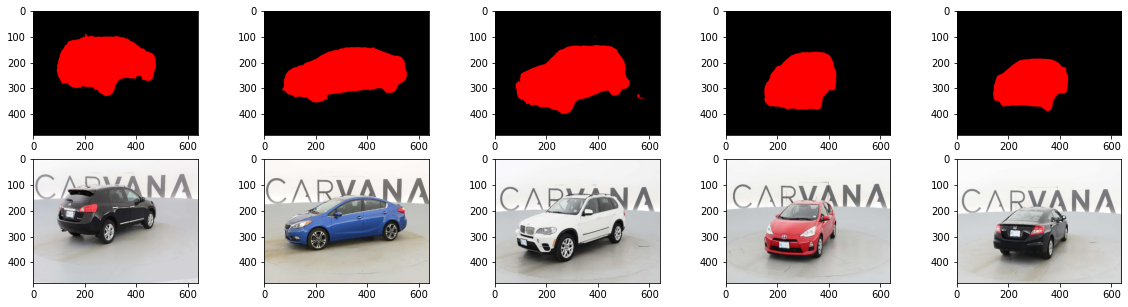

In [ ]:
count = 5 
indexes = np.random.randint(0, len(xTest), count) # Получаем count случайных индексов
print(indexes)
fig, axs = plt.subplots(2, count, figsize=(20, 5)) # Создаем полотно из n графиков
for i, idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model_for_test.predict(xTest[idx].reshape(1, 480, 640, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr = pr.reshape(-1, num_classes) # Решейпим предикт
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
        pr1.append(index2color(pr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(480, 640, 3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(xTest[idx].astype('uint8'))) # Отображаем на графике во второй линии оригинальное изображение        
plt.show() 

### Тест сегментации конкретного автомобиля

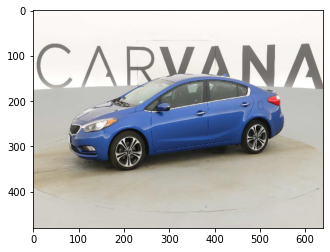

In [ ]:
# Загрузка изображения с размерностями, что требует нейросеть.
car = image.load_img('/content/cars-carvana-processed_640w_480h_test_only/0a943856ea46_04.jpg')
car_loaded = car
plt.imshow(car)

In [ ]:
# Переводим изображение в numpy-массив
car_rgba = car.convert("RGBA") # Изображение в RGB, а для того, чтобы сделать все пиксели, кроме авто прозрачными, нужен RGBA

# Изображение в RGB для получения предикта НС
car_arr = image.img_to_array(car)
print(car_arr.shape)
print(type(car_arr))

(480, 640, 3)
<class 'numpy.ndarray'>


1/1 [==============================] - 0s 26ms/step


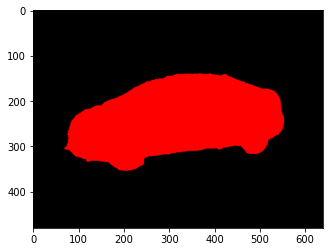

In [ ]:
predict = model_for_test.predict(car_arr.reshape(1, img_height, img_width, 3)) # Предиктим картику
predict = predict.reshape(-1, num_classes) # Решейпим предикт

pr1 = [] # Пустой лист под сегментированную картинку из predicta

for k in range(len(predict)): # Проходим по всем уровням (количесвто классов)
    pr1.append(index2color(predict[k])) # Переводим индекс в писксель

pr1 = np.array(pr1) # Преобразуем в numpy
pr1 = pr1.reshape(img_height, img_width, 3) # Решейпим к размеру изображения
img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
img = img.convert("RGBA")
plt.imshow(img)

In [ ]:
# Переводим маску в numpy-массив
car_seg_arr = image.img_to_array(img)
print(car_seg_arr.shape)
print(type(car_seg_arr))

(480, 640, 4)
<class 'numpy.ndarray'>


In [ ]:
# Вырезаю автомобиль по маске

# 1) Перевести изображения в numpy массивы

# Собираю информацию о размерах изображений (они одинаковы)
car_width  = car_rgba.size[0]     # Получаем ширину
car_height = car_rgba.size[1]     # Получаем высоту
print("car_img", car_height, car_width)

# Перевожу изображения в массивы
car_data = car_rgba.getdata()              # Получаем данные картинки
car_arr = np.array(car_data)          # Преобразуем в np массив
car_arr = car_arr.reshape(car_height, car_width, 4)         # Возращаем нужную конфигурацию np массиву
print("car_arr", car_arr.shape)

seg_car_data = img.getdata()      # Получаем данные картинки
seg_car_arr = np.array(seg_car_data)  # Преобразуем в np массив
seg_car_arr = seg_car_arr.reshape(car_height, car_width, 4) # Возращаем нужную конфигурацию np массиву
print("seg_car_arr", seg_car_arr.shape)

car_img 480 640
car_arr (480, 640, 4)
seg_car_arr (480, 640, 4)


In [ ]:
# 2) Итерация по массиву изображения сегментированной машины.
# Необходимо брать цвет каждого пикселя. 
# Если он не красный - установить значение этого же пикселя у изображения машины на прозрачный.

for y in range(car_rgba.size[1]): # по строкам высоты
    for x in range(car_rgba.size[0]): # по столбцам строки
        if seg_car_arr[y][x][0] <= 10: # красного цветам мало [y][x][r,g,b,a]
            car_arr[y][x] = [0,0,0,0] # Делаю прозрачным

In [ ]:
# 3) Возращаю изображение из массива в картинки
car_arr = car_arr.astype('uint8')
car = Image.fromarray(car_arr)

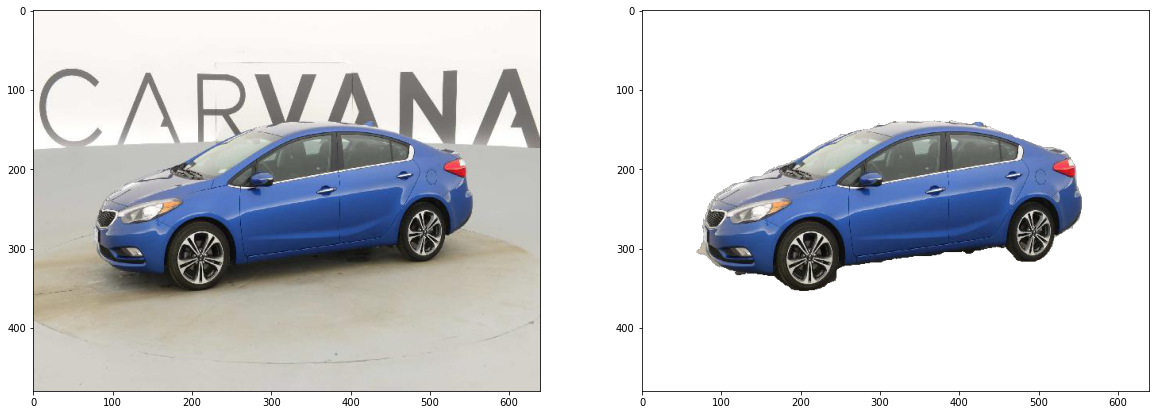

In [ ]:
# Изображения после вырезки
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # Создаем полотно нужной размерности

axs[0].imshow(car_loaded)     # Отображаем исходную машину
axs[1].imshow(car)            # Отображаем вырезанную машину

plt.show() # Показываем изображения